In [1]:
import argparse
import os
import pathlib
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import tifffile
import torch
import tqdm
from PIL import Image
from rich.pretty import pprint
from stardist.models import StarDist2D
from ultrack import to_tracks_layer, track, tracks_to_zarr
from ultrack.config import MainConfig
from ultrack.imgproc import normalize
from ultrack.utils import estimate_parameters_from_labels, labels_to_contours

# check if in a jupyter notebook

try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(f"Running in notebook: {in_notebook}")

os.environ["OMP_NUM_THREADS"] = "8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# check gpu
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if not gpu_devices:
    print("No GPU found")
else:
    print("GPU found")


# tensorflow clear gpu memory
def clear_gpu_memory():
    from numba import cuda

    cuda.select_device(0)
    cuda.close()


clear_gpu_memory()

2024-12-30 13:50:08.177071: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-30 13:50:08.177098: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-30 13:50:08.177103: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 13:50:08.211586: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running in notebook: True
GPU found


2024-12-30 13:50:11.523040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-30 13:50:11.606648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-30 13:50:11.609808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir_main",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    args = parser.parse_args()
    input_dir_main = pathlib.Path(args.input_dir_main).resolve(strict=True)
else:
    print("Running in a notebook")
    input_dir_main = pathlib.Path(
        "../../2.illumination_correction/illum_directory/20241028T111908_W0323_F0005/"
    ).resolve(strict=True)

temporary_output_dir = pathlib.Path("../tmp_output").resolve()
figures_output_dir = pathlib.Path("../figures").resolve()
results_output_dir = pathlib.Path("../results").resolve()
temporary_output_dir.mkdir(exist_ok=True)
figures_output_dir.mkdir(exist_ok=True)
results_output_dir.mkdir(exist_ok=True)

Running in a notebook


FileNotFoundError: [Errno 2] No such file or directory: '../../2.cellprofiler_ic_processing'

In [3]:
file_extensions = {".tif", ".tiff"}
# get all the tiff files
tiff_files = list(input_dir_main.glob("*"))
tiff_files = [f for f in tiff_files if f.suffix in file_extensions]
tiff_files = sorted(tiff_files)

tiff_files_terminal = list(input_dir_terminal.glob("*"))
tiff_files_terminal = [f for f in tiff_files_terminal if f.suffix in file_extensions]
tiff_files_terminal = sorted(tiff_files_terminal)

tiff_files = tiff_files + tiff_files_terminal
tiff_files = [f for f in tiff_files if "C01" in f.name]

print(f"Found {len(tiff_files)} tiff files in the input directory")

Found 14 tiff files in the input directory


In [4]:
model = StarDist2D.from_pretrained("2D_versatile_fluo")

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2024-12-29 13:11:59.516253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-29 13:11:59.517573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-29 13:11:59.518547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
image_dims = tifffile.imread(tiff_files[0]).shape
timelapse_raw = np.zeros(
    (len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16
)
timelapse_raw_visualize = np.zeros(
    (len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16
)
stardist_labels = np.zeros(
    (len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16
)

In [6]:
# import stardist
for image_index, image_file_path in tqdm.tqdm(enumerate(tiff_files)):
    image = tifffile.imread(image_file_path)
    timelapse_raw_visualize[image_index, :, :] = image
    image = normalize(image, gamma=1.0)
    timelapse_raw[image_index, :, :] = image

    segmented_image, _ = model.predict_instances(image)
    stardist_labels[image_index, :, :] = segmented_image
# concat all the images into one array
print(stardist_labels.shape)

0it [00:00, ?it/s]2024-12-29 13:12:00.388730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
14it [00:06,  2.11it/s]

(14, 1900, 1900)


In [7]:
detections = np.zeros((len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16)
edges = np.zeros((len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16)
for frame_index, frame in enumerate(stardist_labels):
    detections[frame_index, :, :], edges[frame_index, :, :] = labels_to_contours(frame)
print(detections.shape, edges.shape)
tifffile.imwrite(f"{temporary_output_dir}/stardist_labels.tif", stardist_labels)
tifffile.imwrite(f"{temporary_output_dir}/timelapse_raw.tif", timelapse_raw)
tifffile.imwrite(f"{temporary_output_dir}/detections.tif", detections)
tifffile.imwrite(f"{temporary_output_dir}/edges.tif", edges)

clear_gpu_memory()

Converting labels to contours: 100%|██████████| 1900/1900 [00:01<00:00, 1845.56it/s]


(14, 1900, 1900) (14, 1900, 1900)


Estimating params.: 100%|██████████| 14/14 [00:00<00:00, 52.14it/s]


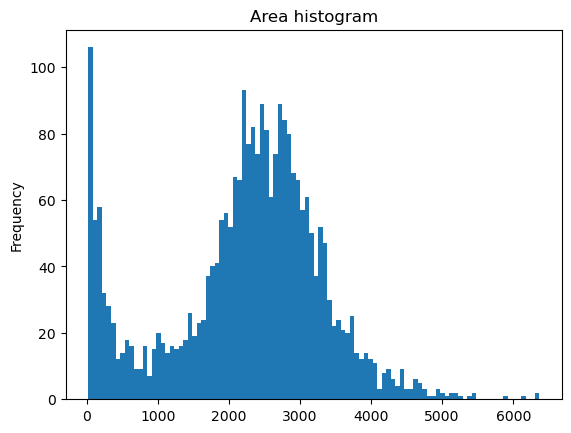

In [8]:
params_df = estimate_parameters_from_labels(stardist_labels, is_timelapse=True)
if in_notebook:
    params_df["area"].plot(kind="hist", bins=100, title="Area histogram")

In [9]:
config = MainConfig()
config.segmentation_config.min_area = 30
config.segmentation_config.max_area = 1250
config.segmentation_config.n_workers = 8
config.linking_config.max_distance = 45
config.linking_config.n_workers = 8

config.tracking_config.appear_weight = -1
config.tracking_config.disappear_weight = -1
config.tracking_config.division_weight = -0.1
config.tracking_config.power = 4
config.tracking_config.bias = -0.001
config.tracking_config.solution_gap = 0.0
config.tracking_config.solver_name = "CBC"
pprint(config.dict())
# write the config to a file for reference later
with open(f"{results_output_dir}/config.json", "w") as f:
    f.write(config.json())

{
│   'data_config': {'n_workers': 1, 'working_dir': '.', 'database': 'sqlite', 'address': None},
│   'segmentation_config': {
│   │   'min_area': 30,
│   │   'max_area': 1250,
│   │   'n_workers': 8,
│   │   'min_frontier': 0.0,
│   │   'threshold': 0.5,
│   │   'max_noise': 0.0,
│   │   'ws_hierarchy': 'area',
│   │   'anisotropy_penalization': 0.0
│   },
│   'linking_config': {
│   │   'max_distance': 45,
│   │   'n_workers': 8,
│   │   'max_neighbors': 5,
│   │   'distance_weight': 0.0,
│   │   'z_score_threshold': 5.0
│   },
│   'tracking_config': {
│   │   'solver_name': 'CBC',
│   │   'appear_weight': -1,
│   │   'disappear_weight': -1,
│   │   'division_weight': -0.1,
│   │   'n_threads': -1,
│   │   'window_size': None,
│   │   'overlap_size': 1,
│   │   'solution_gap': 0.0,
│   │   'time_limit': 36000,
│   │   'method': 0,
│   │   'link_function': 'power',
│   │   'power': 4,
│   │   'bias': -0.001,
│   │   'dismiss_weight_guess': None,
│   │   'include_weight_guess': None
│   }
}

In [10]:
track(
    foreground=detections,
    edges=edges,
    config=config,
    overwrite=True,
)

Linking nodes.: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


Using Coin-OR Branch and Cut solver
Solving ILP batch 0
Constructing ILP ...
Solving ILP ...
Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 5989 (-1789) rows, 10344 (-2292) columns and 18604 (-4297) elements
Clp1000I sum of infeasibilities 7.58398 - average 0.00126632, 4031 fixed columns
Coin0506I Presolve 2103 (-3886) rows, 2840 (-7504) columns and 7106 (-11498) elements
Clp0029I End of values pass after 2617 iterations
Clp0014I Perturbing problem by 0.001% of 1 - largest nonzero change 2.9936918e-05 ( 0.0014968459%) - largest zero change 2.9976734e-05
Clp0000I Optimal - objective value 162.02098
Clp0000I Optimal - objective value 162.02098
Coin0511I After Postsolve, objective 162.02098, infeasibilities - dual 10.573611 (16), primal 0 (0)
Coin0512I Presolved model was optimal, full model needs cleaning up
Clp0014I Perturbing problem by 0.001% of 1 - largest

In [11]:
tracks_df, graph = to_tracks_layer(config)
labels = tracks_to_zarr(config, tracks_df)
tracks_df.to_parquet(
    f"{results_output_dir}/{str(input_dir_main).split('MaxIP_')[1]}_tracks.parquet"
)
tracks_df.head()

Exporting segmentation masks: 100%|██████████| 14/14 [00:00<00:00, 86.88it/s]


,track_id,t,y,x,id,parent_track_id,parent_id
id,,,,,,,
1000003,1,0,16.0,1273.0,1000003,-1,-1
2000010,1,1,41.0,1308.0,2000010,-1,1000003
3000009,1,2,38.0,1291.0,3000009,-1,2000010
4000009,1,3,36.0,1291.0,4000009,-1,3000009
5000007,1,4,35.0,1288.0,5000007,-1,4000009


In [12]:
# save the tracks as parquet
tracks_df.reset_index(drop=True, inplace=True)
tracks = np.zeros((len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16)
cum_tracks_df = tracks_df.copy()
timepoints = tracks_df["t"].unique()

# zero out the track_df
cum_tracks_df = cum_tracks_df.loc[cum_tracks_df["t"] == -1]

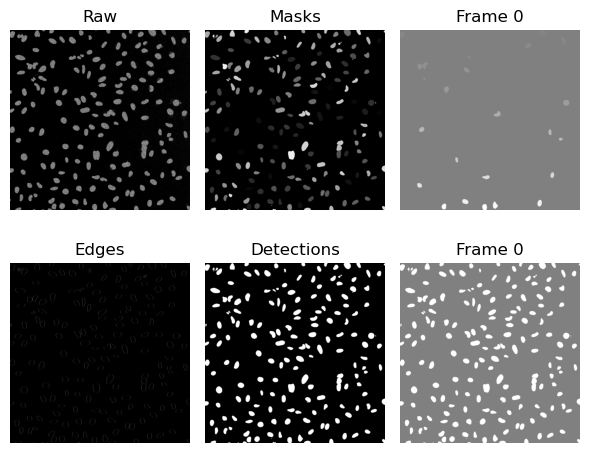

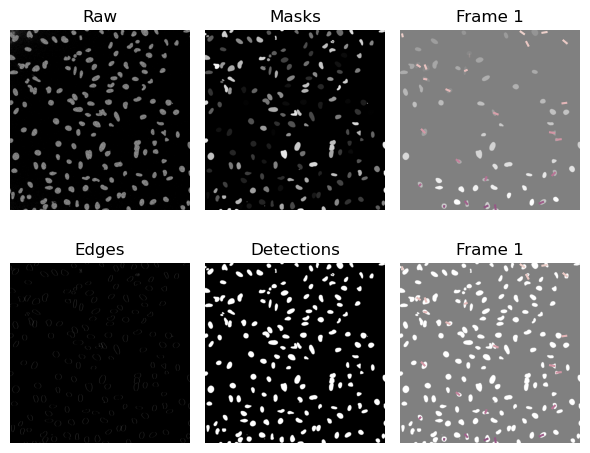

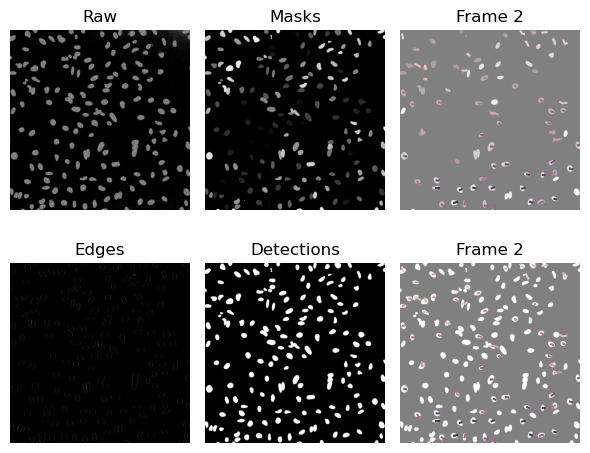

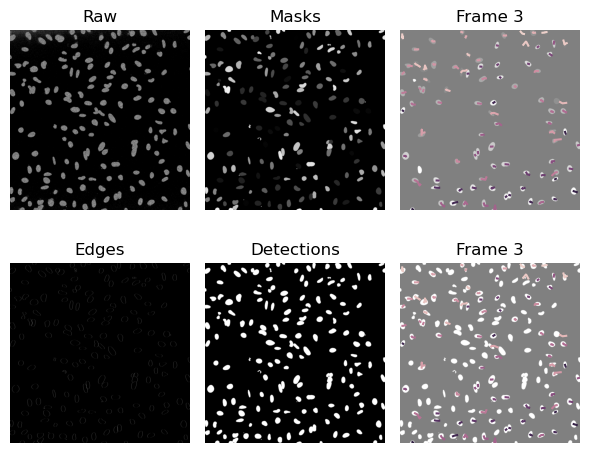

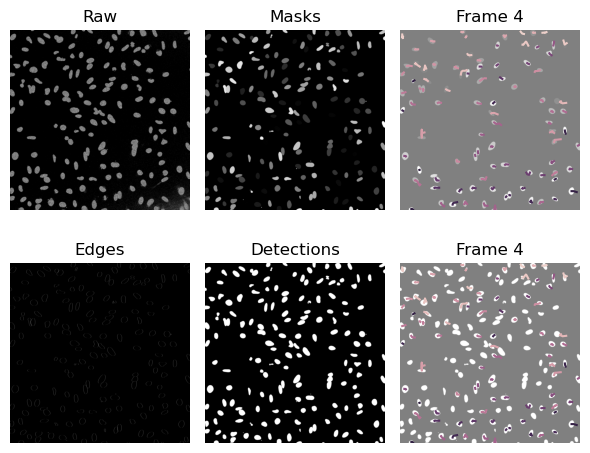

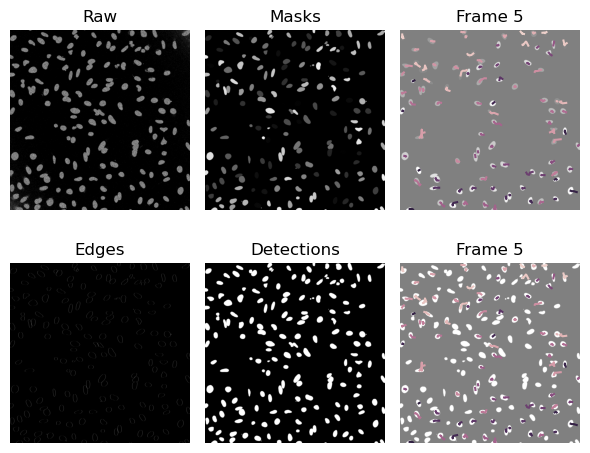

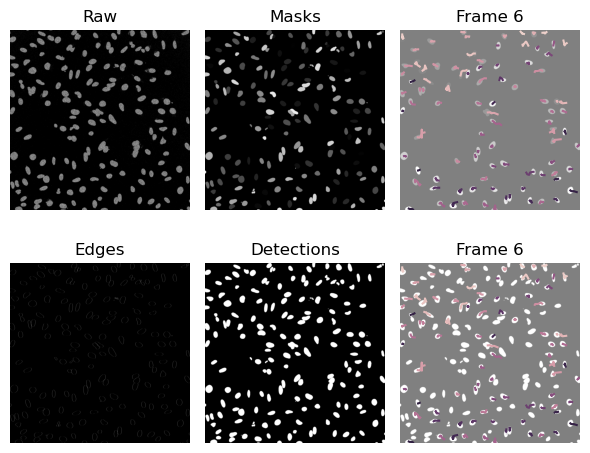

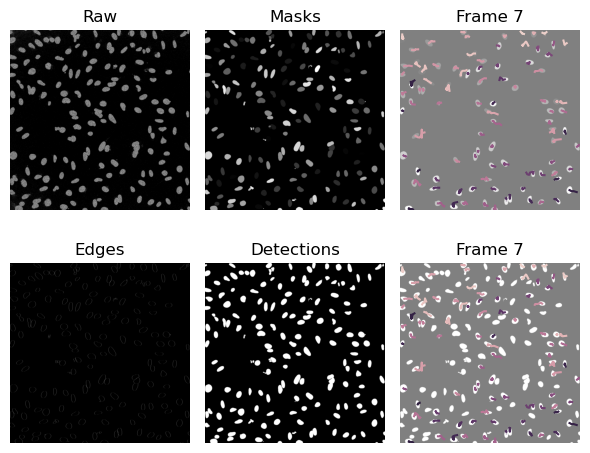

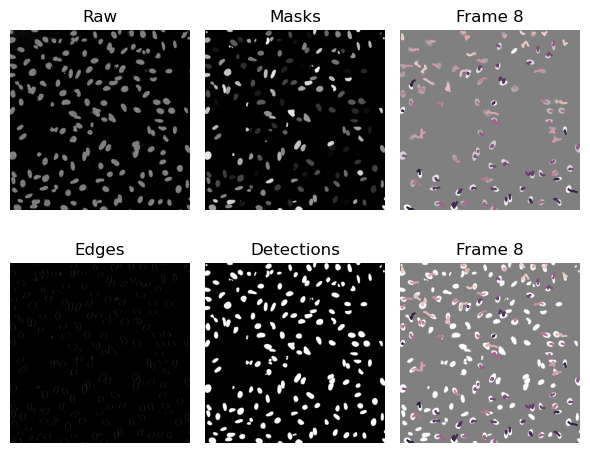

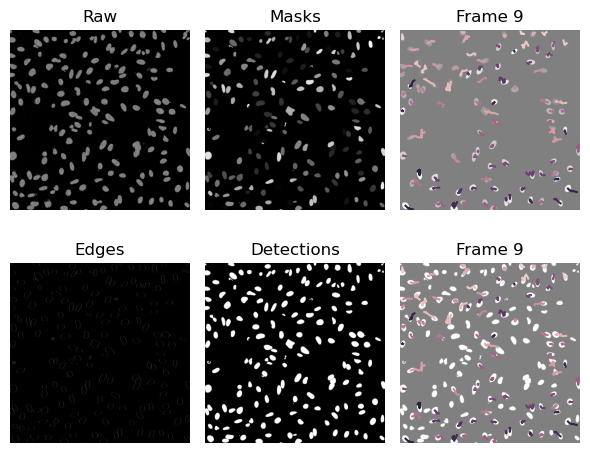

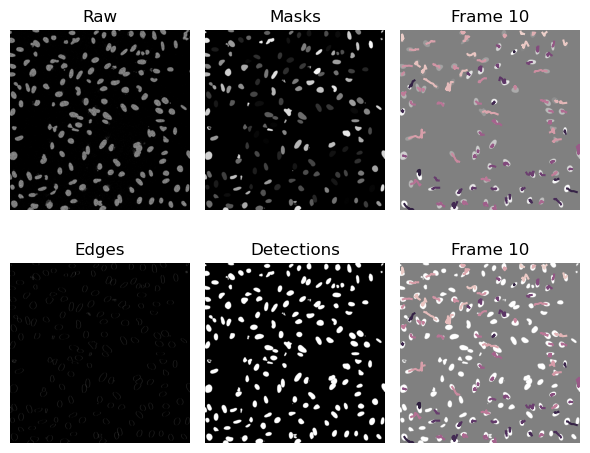

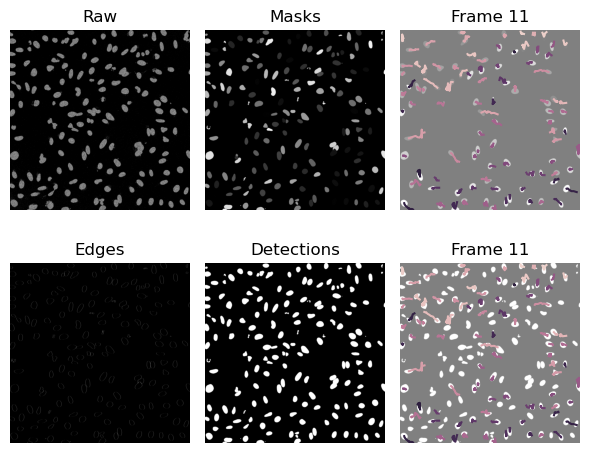

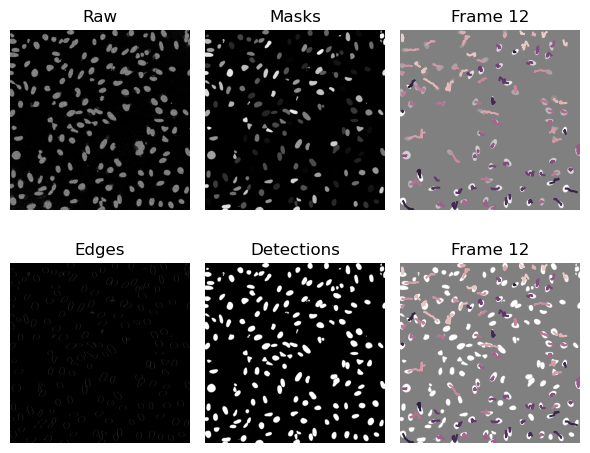

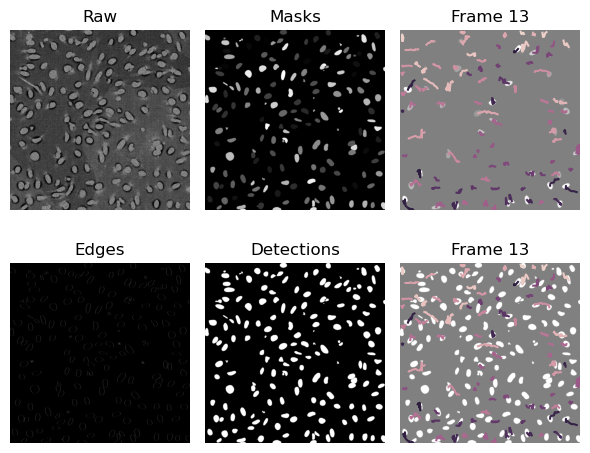

In [13]:
if in_notebook:
    for frame_index, _ in enumerate(timelapse_raw):
        tmp_df = tracks_df.loc[tracks_df["t"] == frame_index]
        cum_tracks_df = pd.concat([cum_tracks_df, tmp_df])
        plt.figure(figsize=(6, 5))
        plt.subplot(2, 3, 1)
        # rescale tbe intensity of the raw image
        raw_image = timelapse_raw_visualize[frame_index, :, :]
        raw_image = raw_image * 4096
        plt.imshow(raw_image, cmap="gray")
        plt.title("Raw")
        plt.axis("off")

        plt.subplot(2, 3, 2)
        plt.imshow(stardist_labels[frame_index, :, :], cmap="gray")
        plt.title("Masks")
        plt.axis("off")

        plt.subplot(2, 3, 3)
        sns.lineplot(data=cum_tracks_df, x="x", y="y", hue="track_id", legend=False)
        plt.imshow(labels[frame_index, :, :], cmap="gray", alpha=0.5)
        plt.title(f"Frame {frame_index}")
        plt.axis("off")

        plt.subplot(2, 3, 4)
        edge_image = skimage.exposure.adjust_gamma(
            edges[frame_index, :, :], gamma=0.0001
        )
        # make the outline brighter
        edge_image = edge_image * 1000
        plt.imshow(edge_image, cmap="gray")
        plt.title("Edges")
        plt.axis("off")

        plt.subplot(2, 3, 5)
        plt.imshow(detections[frame_index, :, :], cmap="gray")
        plt.title("Detections")
        plt.axis("off")

        plt.subplot(2, 3, 6)
        sns.lineplot(data=cum_tracks_df, x="x", y="y", hue="track_id", legend=False)
        plt.imshow(detections[frame_index, :, :], cmap="gray", alpha=0.5)
        plt.title(f"Frame {frame_index}")
        plt.axis("off")

        plt.tight_layout()
        plt.savefig(f"{temporary_output_dir}/tracks_{frame_index}.png")
    if in_notebook:
        plt.show()

In [14]:
# load each image
files = [f for f in temporary_output_dir.glob("*.png")]
files = sorted(files, key=lambda x: int(x.stem.split("_")[1]))
frames = [Image.open(f) for f in files]
fig_path = figures_output_dir / f"{str(input_dir_main).split('MaxIP_')[1]}_tracks.gif"
# plot the line of each track in matplotlib over a gif
# get the tracks
# save the frames as a gif
frames[0].save(fig_path, save_all=True, append_images=frames[1:], duration=3, loop=0)

In [15]:
# clean up tracking files
# remvoe temporary_output_dir
shutil.rmtree(temporary_output_dir)

track_db_path = pathlib.Path("data.db").resolve()
metadata_toml_path = pathlib.Path("metadata.toml").resolve()
if track_db_path.exists():
    track_db_path.unlink()
if metadata_toml_path.exists():
    metadata_toml_path.unlink()

In [16]:
clear_gpu_memory()